In [1]:
import hmftpy as hmf
from hmftpy.plaquettes.triangular import plaq12, plaq12z, plaq9p, plaq9d, plaq3
from hmftpy.operators import mf_ops, inner_hamiltonian, periodic_hamiltonian
from hmftpy import do_hmft
from hmftpy.hmf import get_mfs
from hmftpy.plot_spins import draw_tri_lattice, draw_cluster, plot_spins
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

plaq = plaq12
L = plaq['L']
basis = spin_basis_1d(L, pauli=0)

ops = hmf.operators.mf_ops(plaq, basis)
maxit=50
steps = 40

I want to look for singlet correlations forming within the 4-site diamonds in the lattice.
There are two arrangements of these diamonds that have the appropriate $C_3$ symmetry. Here, I will plot a single one of those diamonds.

In [2]:
def plot_line(a, b, color='black'):
    plt.plot([a[0], b[0]], [a[1], b[1]], color=color)

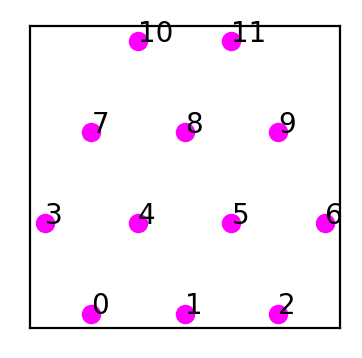

In [3]:
a1 = np.array((1, 0))
a2 = np.array((-0.5, 0.5*np.sqrt(3)))
a0 = np.array((0.5, 0.5*np.sqrt(3)))

b1 = 2*np.pi*np.array((1, -1/np.sqrt(3)))
b2 = 4*np.pi*np.array((0, 1/np.sqrt(3)))

M = np.pi*np.array((1, 1/np.sqrt(3)))
K = np.pi*np.array((4/3, 0))

plt.figure(figsize=(2,2), dpi=200)
rs = [(0,0), a1, 2*a1,
      a2, a2+a1, a2+2*a1, a2+3*a1,
      2*a2+a1, 2*a2+2*a1, 2*a2+3*a1,
      3*a2+2*a1, 3*a2+3*a1]
rx = [r[0] for r in rs]
ry = [r[1] for r in rs]
plt.scatter(rx, ry, color='magenta')
for i, r in enumerate(rs):
    plt.text(r[0], r[1], i)

plt.xticks([])
plt.yticks([])
plt.show()

I want to look at a superposition of singlets along the red and blue bonds:

\begin{align}
C_\diamond^r =& \vec \sigma_0 \cdot \vec \sigma_1 + \vec \sigma_3 \cdot \vec\sigma_4\\
C_\diamond^b =& \vec \sigma_0 \cdot \vec \sigma_3 + \vec \sigma_1 \cdot \vec\sigma_4
\end{align}

Alternatively, we can look at singlets on the green/orange bonds:
\begin{align}
C_\diamond^g =& \vec \sigma_1 \cdot \vec \sigma_2 + \vec \sigma_5 \cdot \vec\sigma_6\\
C_\diamond^o =& \vec \sigma_1 \cdot \vec \sigma_5 + \vec \sigma_2 \cdot \vec\sigma_6
\end{align}

In [4]:
reds = [[0,1], [3,4], [7,10], [8,11], [2,5], [6,9]]
blues = [[0,3], [1,4], [7,8], [10,11], [2,6], [5,9]]

greens = [[1,5], [2,6], [8,9], [10,11], [0,3], [4,7]]
oranges = [[1,2], [5,6], [8,10], [9,11], [0,4], [3,7]]

red_op_lst = [['xx', [[1, r[0], r[1]] for r in reds]],
              ['yy', [[1, r[0], r[1]] for r in reds]],
              ['zz', [[0, r[0], r[1]] for r in reds]]]
blue_op_lst = [['xx', [[1, b[0], b[1]] for b in blues]],
               ['yy', [[1, b[0], b[1]] for b in blues]],
               ['zz', [[0, b[0], b[1]] for b in blues]]]
green_op_lst = [['xx', [[1, r[0], r[1]] for r in greens]],
              ['yy', [[1, r[0], r[1]] for r in greens]],
              ['zz', [[0, r[0], r[1]] for r in greens]]]
orange_op_lst = [['xx', [[1, b[0], b[1]] for b in oranges]],
               ['yy', [[1, b[0], b[1]] for b in oranges]],
               ['zz', [[0, b[0], b[1]] for b in oranges]]]
red_ops = quantum_operator({'static': red_op_lst}, basis=basis)
blue_ops = quantum_operator({'static': blue_op_lst}, basis=basis)
green_ops = quantum_operator({'static': green_op_lst}, basis=basis)
orange_ops = quantum_operator({'static': orange_op_lst}, basis=basis)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


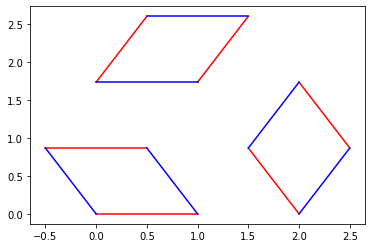

In [5]:
for r in reds:
    r1 = rs[r[0]]
    r2 = rs[r[1]]
    plot_line(r1, r2, color='red')
for b in blues:
    r1 = rs[b[0]]
    r2 = rs[b[1]]
    plot_line(r1, r2, color='blue')

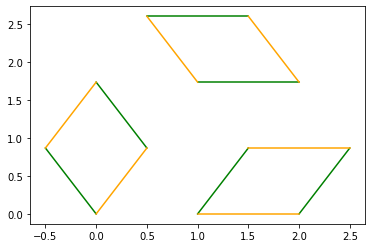

In [6]:
for g in greens:
    r1 = rs[g[0]]
    r2 = rs[g[1]]
    plot_line(r1, r2, color='green')
for o in oranges:
    r1 = rs[o[0]]
    r2 = rs[o[1]]
    plot_line(r1, r2, color='orange')

We should also consider dimers. Note that the four colors mentioned above form all the non-competing dimer structures. 

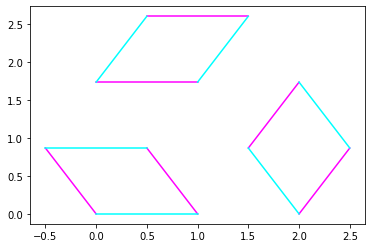

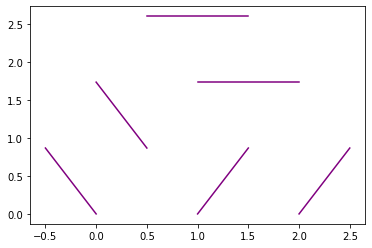

In [7]:
pinks = [[0,3], [1,4], [2,6], [5,9], [7,8], [10,11]]
purps = [[0,3], [4,7], [2,6], [1,5], [8,9], [10,11]]
cyans = [[0,1], [3,4], [2,5], [6,9], [7,10], [8,11]]
for p in pinks:
    r1 = rs[p[0]]
    r2 = rs[p[1]]
    plot_line(r1, r2, color='magenta')
for p in cyans:
    r1 = rs[p[0]]
    r2 = rs[p[1]]
    plot_line(r1, r2, color='cyan')
plt.show()
for p in purps:
    r1 = rs[p[0]]
    r2 = rs[p[1]]
    plot_line(r1, r2, color='purple')
plt.show()


## Low $J_2$ phase

In [8]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .01, 'yy': .01, 'zz': 0}}
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=None, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
print('Energy: {}'.format(e))
print('Converged? {}'.format(cvg))

Energy: -4.357977947618582
Converged? True


In [9]:
r = red_ops.matrix_ele(v, v)
print('Red correlator: {}'.format(r))
b = blue_ops.matrix_ele(v, v)
print('Blue correlator: {}'.format(b))
g = green_ops.matrix_ele(v, v)
print('Green correlator: {}'.format(r))
o = orange_ops.matrix_ele(v, v)
print('Orange correlator: {}'.format(b))

cw = (red_ops + blue_ops).matrix_ele(v,v)
print('Clockwise correlator: {}'.format(cw))
ccw = (green_ops + orange_ops).matrix_ele(v,v)
print('Clockwise correlator: {}'.format(ccw))

Red correlator: (-0.8212685219737742+4.163336342344337e-17j)
Blue correlator: (-1.3217406773633578-6.938893903907228e-17j)
Green correlator: (-0.8212685219737742+4.163336342344337e-17j)
Orange correlator: (-1.3217406773633578-6.938893903907228e-17j)
Clockwise correlator: (-2.1430091993371323-1.3877787807814457e-16j)
Clockwise correlator: (-2.1426828716384296+2.7755575615628914e-17j)


# Disordered phase

In [10]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .18, 'yy': .18, 'zz': 0}}
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=None, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
print('Energy: {}'.format(e))
print('Converged? {}'.format(cvg))

Energy: -3.748188885819312
Converged? True


In [11]:
r = red_ops.matrix_ele(v, v)
print('Red correlator: {}'.format(r))
b = blue_ops.matrix_ele(v, v)
print('Blue correlator: {}'.format(b))
g = green_ops.matrix_ele(v, v)
print('Green correlator: {}'.format(r))
o = orange_ops.matrix_ele(v, v)
print('Orange correlator: {}'.format(b))

cw = (red_ops + blue_ops).matrix_ele(v,v)
print('Clockwise correlator: {}'.format(cw))
ccw = (green_ops + orange_ops).matrix_ele(v,v)
print('Clockwise correlator: {}'.format(ccw))

Red correlator: (-0.8611167110656412+0j)
Blue correlator: (-1.4161734885673731-1.1102230246251565e-16j)
Green correlator: (-0.8611167110656412+0j)
Orange correlator: (-1.4161734885673731-1.1102230246251565e-16j)
Clockwise correlator: (-2.277290199633014-1.1102230246251565e-16j)
Clockwise correlator: (-2.2772902671610797-2.7755575615628914e-16j)


# Stripey phase

In [12]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .5, 'yy': .5, 'zz': 0}}
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=None, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
print('Energy: {}'.format(e))
print('Converged? {}'.format(cvg))

Energy: -4.8421973872516855
Converged? True


In [13]:
r = red_ops.matrix_ele(v, v)
print('Red correlator: {}'.format(r))
b = blue_ops.matrix_ele(v, v)
print('Blue correlator: {}'.format(b))
g = green_ops.matrix_ele(v, v)
print('Green correlator: {}'.format(r))
o = orange_ops.matrix_ele(v, v)
print('Orange correlator: {}'.format(b))

cw = (red_ops + blue_ops).matrix_ele(v,v)
print('Clockwise correlator: {}'.format(cw))
ccw = (green_ops + orange_ops).matrix_ele(v,v)
print('Clockwise correlator: {}'.format(ccw))

Red correlator: (-0.7684981162086703+1.734723475976807e-18j)
Blue correlator: (-0.7487910815721763-6.938893903907228e-18j)
Green correlator: (-0.7684981162086703+1.734723475976807e-18j)
Orange correlator: (-0.7487910815721763-6.938893903907228e-18j)
Clockwise correlator: (-1.5172891977808463-2.0816681711721685e-17j)
Clockwise correlator: (-1.4194395810634024+4.163336342344337e-17j)


# Correlators in individual diamonds


In [14]:
reds = [[0,1], [3,4], [7,10], [8,11], [2,5], [6,9]]
blues = [[0,3], [1,4], [7,8], [10,11], [2,6], [5,9]]

greens = [[1,5], [2,6], [8,9], [10,11], [0,3], [4,7]]
oranges = [[1,2], [5,6], [8,10], [9,11], [0,4], [3,7]]


diam_1 = [[
            [[0,1], [3,4]],
            [[0,3], [1,4]]
            ],[
            [[7,10], [8,11]],
            [[7,8], [10,11]]
            ],[
            [[2,5], [6,9]],
            [[2,6], [5,9]]
            ]]

diam_2 = [[
            [[1,5], [2,6]],
            [[1,2], [5,6]]
            ],[
            [[8,9], [10,11]],
            [[8,10], [9,11]]
            ],[
            [[0,3], [4,7]],
            [[0,4], [3,7]]
            ]]

diam_1_lst = [[] for i in range(3)]
diam_2_lst = [[] for i in range(3)]

for i in range(3):
    d = diam_1[i]
    r_bonds = d[0]
    b_bonds = d[1]
    diam_1_lst[i] += [['xx', [[1, r[0], r[1]] for r in r_bonds]],
                         ['yy', [[1, r[0], r[1]] for r in r_bonds]],
                         ['zz', [[1, r[0], r[1]] for r in r_bonds]]]
    d = diam_2[i]
    r_bonds = d[0]
    b_bonds = d[1]
    diam_2_lst[i] += [['xx', [[1, b[0], b[1]] for b in b_bonds]],
                         ['yy', [[1, b[0], b[1]] for b in b_bonds]],
                         ['zz', [[1, b[0], b[1]] for b in b_bonds]]]

diam_1_ops = [quantum_operator({'static': dl}, basis=basis) for dl in diam_1_lst]
diam_2_ops = [quantum_operator({'static': dl}, basis=basis) for dl in diam_2_lst]

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


In [15]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .01, 'yy': .01, 'zz': 0}}
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=None, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
print('Energy: {}'.format(e))
print('Converged? {}'.format(cvg))

Energy: -4.3579779485024766
Converged? True


In [16]:
print('Clockwise diamonds')
diamonds = [d.expt_value(v) for d in diam_1_ops]
print('Diamond expt values')
for d in diamonds:
    print(d)
print('Diamond correlators')
print('0-1')
print(diam_1_ops[0].matrix_ele(diam_1_ops[1].dot(v), v))
print('0-2')
print(diam_1_ops[0].matrix_ele(diam_1_ops[2].dot(v), v))
print('')
print('Counterclockwise diamonds')
diamonds = [d.expt_value(v) for d in diam_2_ops]
print('Diamond expt values')
for d in diamonds:
    print(d)
print('Diamond correlators')
print('0-1')
print(diam_2_ops[0].matrix_ele(diam_2_ops[1].dot(v), v))
print('0-2')
print(diam_2_ops[0].matrix_ele(diam_2_ops[2].dot(v), v))

Clockwise diamonds
Diamond expt values
(-0.4534954475308618+2.0816681711721685e-17j)
(-0.3725307050953844+5.551115123125783e-17j)
(-0.25912405536624905+1.214306433183765e-17j)
Diamond correlators
0-1
(0.23754416389770214-3.469446951953614e-18j)
0-2
(0.18995908509751525+2.7755575615628914e-17j)

Counterclockwise diamonds
Diamond expt values
(-0.45321876645126946+3.469446951953614e-17j)
(-0.37115628939084866-3.469446951953614e-18j)
(-0.25919265170556305+1.3877787807814457e-17j)
Diamond correlators
0-1
(0.236514675209391+1.734723475976807e-17j)
0-2
(0.1901076135422527+0j)


In [17]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .18, 'yy': .18, 'zz': 0}}
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=None, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
print('Energy: {}'.format(e))
print('Converged? {}'.format(cvg))

Energy: -3.748188886258615
Converged? True


In [18]:
print('Clockwise diamonds')
diamonds = [d.expt_value(v) for d in diam_1_ops]
print('Diamond expt values')
for d in diamonds:
    print(d)
print('Diamond correlators')
print('0-1')
print(diam_1_ops[0].matrix_ele(diam_1_ops[1].dot(v), v))
print('0-2')
print(diam_1_ops[0].matrix_ele(diam_1_ops[2].dot(v), v))
print('')
print('Counterclockwise diamonds')
diamonds = [d.expt_value(v) for d in diam_2_ops]
print('Diamond expt values')
for d in diamonds:
    print(d)
print('Diamond correlators')
print('0-1')
print(diam_2_ops[0].matrix_ele(diam_2_ops[1].dot(v), v))
print('0-2')
print(diam_2_ops[0].matrix_ele(diam_2_ops[2].dot(v), v))

Clockwise diamonds
Diamond expt values
(-0.4071971096358347-1.3877787807814457e-17j)
(-0.4071971116912445-2.0816681711721685e-17j)
(-0.40719710067580644+6.938893903907228e-18j)
Diamond correlators
0-1
(0.34373548421711175+1.3877787807814457e-17j)
0-2
(0.34373548189418174+0j)

Counterclockwise diamonds
Diamond expt values
(-0.40719713281798625+4.163336342344337e-17j)
(-0.4071971262482462-1.3877787807814457e-17j)
(-0.4071971288626114-3.469446951953614e-17j)
Diamond correlators
0-1
(0.3437355022051066+1.3877787807814457e-17j)
0-2
(0.34373550314340634+2.0816681711721685e-17j)


In [19]:
interactions = {'local': {},
                'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                'n_nearest': {'xx': .5, 'yy': .5, 'zz': 0}}
e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                        max_iter=maxit, mf0=None, 
                        ops=ops, hmft_tol=10**-8,
                        lanczos_tol=10**-11,
                        mf_cvg=False, every_other=True)
print('Energy: {}'.format(e))
print('Converged? {}'.format(cvg))

Energy: -4.838965480009321
Converged? False


In [20]:
print('Clockwise diamonds')
diamonds = [d.expt_value(v) for d in diam_1_ops]
print('Diamond expt values')
for d in diamonds:
    print(d)
print('Diamond correlators')
print('0-1')
print(diam_1_ops[0].matrix_ele(diam_1_ops[1].dot(v), v))
print('0-2')
print(diam_1_ops[0].matrix_ele(diam_1_ops[2].dot(v), v))
print('')
print('Counterclockwise diamonds')
diamonds = [d.expt_value(v) for d in diam_2_ops]
print('Diamond expt values')
for d in diamonds:
    print(d)
print('Diamond correlators')
print('0-1')
print(diam_2_ops[0].matrix_ele(diam_2_ops[1].dot(v), v))
print('0-2')
print(diam_2_ops[0].matrix_ele(diam_2_ops[2].dot(v), v))

Clockwise diamonds
Diamond expt values
(0.4346998885153528+5.551115123125783e-17j)
(-0.6652270274922638-2.7755575615628914e-17j)
(-0.6332413073865804+8.326672684688674e-17j)
Diamond correlators
0-1
(-0.29575345592814967+1.3877787807814457e-17j)
0-2
(-0.28349624997808964-2.7755575615628914e-17j)

Counterclockwise diamonds
Diamond expt values
(0.4167177136348801-1.3877787807814457e-17j)
(-0.658697316879862+0j)
(-0.6668631559367517-8.326672684688674e-17j)
Diamond correlators
0-1
(-0.28117229268472654-2.7755575615628914e-17j)
0-2
(-0.2815293198292905+5.551115123125783e-17j)


# Running a path
Let's go from low J2 to high J2:

In [21]:
J2s = np.linspace(0, 0.19, steps)
diamonds_cw = np.zeros((3, steps))
diamonds_ccw = np.zeros((3, steps))
dimers = np.zeros((4,steps))
dimer_ops = [red_ops, blue_ops, green_ops, orange_ops]

energies = np.zeros(steps)

In [22]:
mf = None
for i, J2 in enumerate(tqdm(J2s)):
    interactions = {'local': {},
                    'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                    'n_nearest': {'xx': J2, 'yy': J2, 'zz': 0}}
    e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                            max_iter=maxit, mf0=mf, 
                            ops=ops, hmft_tol=10**-8,
                            lanczos_tol=10**-11,
                            mf_cvg=False, every_other=True)
    energies[i] = e
    diamonds_cw[:,i] = [d.expt_value(v) for d in diam_1_ops]
    diamonds_ccw[:,i] = [d.expt_value(v) for d in diam_2_ops]
    dimers[:, i] = [d.expt_value(v) for d in dimer_ops]


  0%|          | 0/40 [00:00<?, ?it/s]/Users/wholdhus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/Users/wholdhus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/wholdhus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
100%|██████████| 40/40 [03:30<00:00,  5.26s/it]


Now, let's go from the stripey phase into the disordered phase

In [23]:
J2s_2 = np.linspace(.4, .2, steps)
diamonds_cw_2 = np.zeros((3, steps))
diamonds_ccw_2 = np.zeros((3, steps))
energies_2 = np.zeros(steps)
dimers_2 = np.zeros((4, steps))

In [24]:
mf = None
for i, J2 in enumerate(tqdm(J2s_2)):
    interactions = {'local': {},
                    'nearest': {'xx': 1, 'yy': 1, 'zz': 0},
                    'n_nearest': {'xx': J2, 'yy': J2, 'zz': 0}}
    e, v, mf, cvg = do_hmft(plaq, interactions, basis, 
                            max_iter=maxit, mf0=mf, 
                            ops=ops, hmft_tol=10**-8,
                            lanczos_tol=10**-11,
                            mf_cvg=False, every_other=True)
    energies_2[i] = e
    diamonds_cw_2[:,i] = [d.expt_value(v) for d in diam_1_ops]
    diamonds_ccw_2[:,i] = [d.expt_value(v) for d in diam_2_ops]
    dimers_2[:, i] = [d.expt_value(v) for d in dimer_ops]


  0%|          | 0/40 [00:00<?, ?it/s]/Users/wholdhus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/Users/wholdhus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/Users/wholdhus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  
100%|██████████| 40/40 [01:13<00:00,  1.84s/it]


In [25]:
J2a = np.concatenate((J2s, J2s_2[::-1]))
diamonds_cw_a = np.concatenate((diamonds_cw, diamonds_cw_2[:, ::-1]), axis=1)
diamonds_ccw_a = np.concatenate((diamonds_ccw, diamonds_ccw_2[:, ::-1]), axis=1)
dimers_a = np.concatenate((dimers, dimers_2[:, ::-1]), axis=1)

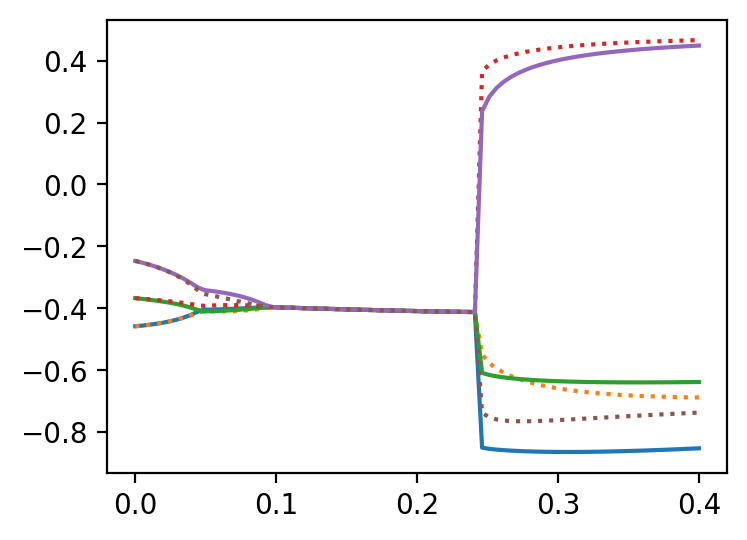

In [26]:
plt.figure(figsize=(4,3), dpi=200)
for i in range(3):
    plt.plot(J2a, diamonds_cw_a[i,:])
    plt.plot(J2a, diamonds_ccw_a[i,:], ls=':')

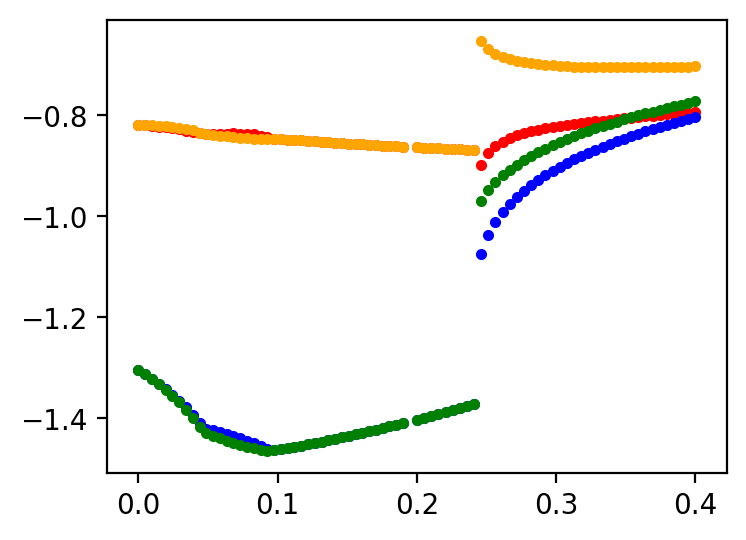

In [27]:
plt.figure(figsize=(4,3), dpi=200)
colors = ['red', 'blue', 'green', 'orange']
for i in range(4):
    plt.scatter(J2a, dimers_a[i,:], color=colors[i], marker='.')